# Analyzing Researchers affiliations over time 

What we'll cover in this notebooks

* how to extract researchers data related to an institution 
* how to examine historical affiliations data 
* how to plot these data on a map so to be analysed further

## 1. Load libraries and log in

In [1]:
# @markdown # Get the API library and login 
# @markdown **Privacy tip**: leave the password blank and you'll be asked for it later. This can be handy on shared computers.
username = ""  #@param {type: "string"}
password = ""  #@param {type: "string"}
endpoint = "https://app.dimensions.ai"  #@param {type: "string"}


# INSTALL/LOAD LIBRARIES 
# ps optimized for Google Colab /modify installation as needed based on your environment
# 
print("==\nInstalling libraries..")
!pip install dimcli plotly_express -U --quiet 

import os
import sys
import time
import json
import pandas as pd
from pandas.io.json import json_normalize
from tqdm import tqdm_notebook as progressbar
import plotly_express as px
import dimcli 
from dimcli.shortcuts import *

# AUTHENTICATION 
# https://github.com/digital-science/dimcli#authentication
#
# == Google Colab users ==
# If username/password not provided, the interactive setup assistant `dimcli --init` is invoked
#
# == Jupyter Notebook users == 
# If username/password not provided, try to use the global API credentials file.
# To create one, open a terminal (File/New/Terminal) and run `dimcli --init` from there
#  
#
print("==\nLogging in..")
if username and password:
  dimcli.login(username, password, endpoint)

if 'google.colab' in sys.modules:
  print("Environment: Google Colab")
  if username and not password:
    import getpass
    password = getpass.getpass(prompt='Password: ')     
    dimcli.login(username, password, endpoint)
  else:
    print("... launching interactive setup assistant")
    !dimcli --init    
    dimcli.login()
else:
  print("Environment: Jupyter Notebook\n... looking for API credentials file")
  dimcli.login()

dsl = dimcli.Dsl()



#
# data-saving utils 
#
DATAFOLDER = "extraction6"
if not os.path.exists(DATAFOLDER):
  !mkdir $DATAFOLDER
  print(f"==\nCreated data folder:", DATAFOLDER + "/")
#
#
def save_as_csv(df, save_name_without_extension):
    "usage: `save_as_csv(dataframe, 'filename')`"
    df.to_csv(f"{DATAFOLDER}/{save_name_without_extension}.csv", index=False)
    print("===\nSaved: ", f"{DATAFOLDER}/{save_name_without_extension}.csv")
   

DimCli v0.6.1 - Succesfully connected to <https://app.dimensions.ai> (method: manual login)


## 2. Choose a Fraunhofer Research Organization

Dimensions uses GRID to identify research-related organizations, eg https://grid.ac/institutes/grid.89170.37 

In [2]:
#@markdown Please choose a specific member of the Fraunhofer Society,  then run this cell.

GRIDID = "grid.461628.f"  #@param ['Fraunhofer Institute for Laser Technology == grid.461628.f', 'Fraunhofer Institute for Molecular Biology and Applied Ecology == grid.418010.c', 'Fraunhofer Institute for Production Technology == grid.461634.2', 'Fraunhofer Research Institution for Casting, Composite and Processing Technology == grid.506241.4', 'Fraunhofer Institute for Telecommunications, Heinrich Hertz Institute == grid.435231.2', 'Fraunhofer Institute for Open Communication Systems == grid.469837.7', 'Fraunhofer Institute for Production Systems and Design Technology == grid.469819.b', 'Fraunhofer Institute for Reliability and Microintegration == grid.469839.9', 'Fraunhofer Institute for Wood Research Wilhelm-Klauditz-Institut == grid.469829.8', 'Fraunhofer Institute for Surface Engineering and Thin Films == grid.462227.7', 'Fraunhofer Institute for Digital Medicine == grid.428590.2', 'Fraunhofer Institute for Manufacturing Technology and Advanced Materials == grid.461617.3', 'Fraunhofer Institute for Wind Energy Systems == grid.8440.8', 'Fraunhofer Institute for Electronic Nano Systems == grid.469847.0', 'Fraunhofer Institute for Machine Tools and Forming Technology == grid.461651.1', 'Fraunhofer Institute for Structural Durability and System Reliability == grid.434481.e', 'Fraunhofer Institute for Computer Graphics Research == grid.461618.c', 'Fraunhofer Institute for Secure Information Technology == grid.469848.f', 'Fraunhofer Institute for Material Flow and Logistics == grid.469827.6', 'Fraunhofer Institute for Software and Systems Engineering == grid.469821.0', 'Fraunhofer Institute for Ceramic Technologies and Systems == grid.461622.5', 'Fraunhofer Institute for Organic Electronics, Electron Beam and Plasma Technology == grid.469851.7', 'Fraunhofer Institute for Photonic Microsystems == grid.469853.5', 'Fraunhofer Institute for Transportation and Infrastructure Systems == grid.469826.7', 'Fraunhofer Institute for Material and Beam Technology == grid.461641.0', 'Fraunhofer Institute for Microelectronic Circuits and Systems == grid.469854.2', 'Fraunhofer Institute for Integrated Circuits == grid.469850.6', 'Fraunhofer Institute for Integrated Circuits == grid.469823.2', 'Fraunhofer Institute for Integrated Systems and Device Technology == grid.469855.3', 'Fraunhofer Institute of Optronics, System Technologies and Image Exploitation == grid.466706.5', 'Fraunhofer Institute for Technological Trend Analysis == grid.469856.0', 'Fraunhofer Institute for Applied Solid State Physics == grid.424642.2', 'Fraunhofer Institute for High-Speed Dynamics, Ernst-Mach-Institut == grid.461627.0', 'Fraunhofer Institute for Physical Measurement Techniques == grid.461631.7', 'Fraunhofer Institute for Solar Energy Systems == grid.434479.9', 'Fraunhofer Institute for Mechanics of Materials == grid.461645.4', 'Fraunhofer Institute for Process Engineering and Packaging == grid.466709.a', 'Fraunhofer Institute for Microstructure of Materials and Systems == grid.469857.1', 'Fraunhofer Research Institution for Additive Manufacturing Technologies == grid.506239.b', 'Fraunhofer Institute for Toxicology and Experimental Medicine == grid.418009.4', 'Fraunhofer Institute for Ceramic Technologies and Systems == grid.461622.5', 'Fraunhofer Institute for Building Physics == grid.469871.5', 'Fraunhofer Institute for Digital Media Technology  == grid.469861.4', 'Fraunhofer Institute for Silicon Technology == grid.469817.5', 'Fraunhofer Institute for Applied Optics and Precision Engineering == grid.418007.a', 'Fraunhofer Institute for Experimental Software Engineering == grid.469863.6', 'Fraunhofer Institute for Industrial Mathematics == grid.461635.3', 'Fraunhofer Institute of Optronics, System Technologies and Image Exploitation == grid.466706.5', 'Fraunhofer Institute for Systems and Innovation Research == grid.459551.9', 'Fraunhofer Institute for Energy Economics and Energy System Technology == grid.506250.4', 'Fraunhofer Center for International Management and Knowledge Economy == grid.462230.1', 'Fraunhofer Institute for Cell Therapy and Immunology == grid.418008.5', 'Fraunhofer Research Institution for Marine Biotechnology and Cell Technology == grid.469834.4', 'Fraunhofer Institute for Factory Operation and Automation == grid.469818.a', 'Fraunhofer Institute for Microengineering and Microsystems == grid.28894.3f', 'Fraunhofer Institute for Embedded Systems and Communication Technologies == grid.469865.0', 'Fraunhofer Research Institution for Microsystems and Solid State Technologies == grid.469866.3', 'Fraunhofer Institute for Applied and Integrated Security == grid.469867.2', 'Fraunhofer Institute for Environmental, Safety, and Energy Technology == grid.424428.c', 'Fraunhofer Institute for Mechatronic Systems Design == grid.469868.d', 'Fraunhofer Institute for Chemical Technology == grid.461616.2', 'Fraunhofer Institute for Applied Polymer Research == grid.461615.1', 'Fraunhofer Research Institution for Large Structures in Production Engineering == grid.506226.5', 'Fraunhofer Institute for Nondestructive Testing == grid.469830.0', 'Fraunhofer Institute for Algorithms and Scientific Computing == grid.418688.b', 'Fraunhofer Institute for Applied Information Technology == grid.469870.4', 'Fraunhofer Institute for Intelligent Analysis and Information Systems == grid.469822.3', 'Fraunhofer Institute for Molecular Biology and Applied Ecology == grid.418010.c', 'Fraunhofer Institute for Industrial Engineering == grid.434477.7', 'Fraunhofer Institute for Building Physics == grid.469871.5', 'Fraunhofer Institute for Interfacial Engineering and Biotechnology == grid.469831.1', 'Fraunhofer Institute for Manufacturing Engineering and Automation == grid.469833.3', 'Fraunhofer Information Center for Planning and Building == grid.469872.6', 'Fraunhofer Institute for Biomedical Engineering == grid.452493.d', 'Fraunhofer Institute for High Frequency Physics and Radar Techniques == grid.461619.d', 'Fraunhofer Institute for Communication, Information Processing and Ergonomics == grid.469836.6', 'Fraunhofer Institute for Silicate Research == grid.424644.4']
    
#@markdown The start/end year of publications used to extract patents
YEAR_START = 2000 #@param {type: "slider", min: 1950, max: 2020}
YEAR_END = 2016 #@param {type: "slider", min: 1950, max: 2020}

if YEAR_END < YEAR_START:
  YEAR_END = YEAR_START

try:
    if "==" in GRIDID: GRIDID = GRIDID.split("==")[1].strip() 
    print("Selection: ", GRIDID)
except:
    print("Please select an organization")
    raise

    
#
# gen link to Dimensions
#

def dimensions_url(grids):
    root = "https://app.dimensions.ai/discover/publication?or_facet_research_org="
    return root + "&or_facet_research_org=".join([x for x in grids])

from IPython.core.display import display, HTML
display(HTML('---<br /><a href="{}">Open {} in Dimensions &#x29c9;</a>'.format(dimensions_url([GRIDID]), GRIDID)))


#@markdown ---

Selection:  grid.461628.f


## 3. Extract the data


In [3]:

print("..extracting data..")
#
# 1. Researchers currently affiliated to this university, by number of publications
#

data1 = dslquery(f"""search researchers where 
                    current_research_org="{GRIDID}" and obsolete=0 
                    return researchers[basics+total_publications] 
                    sort by total_publications limit 1000""")
#
#
#
df1 = data1.as_dataframe()
df1["full_name"] = df1["first_name"] + " " + df1["last_name"]
df1["url"] = "https://app.dimensions.ai/discover/publication?and_facet_researcher=" + df1["id"]


#
# 2. Researchers affiliated to this university at any point in time 
#

data2 = dslquery(f"""search researchers 
                      where research_orgs="{GRIDID}" and obsolete=0 
                      and current_research_org is not empty
                    return researchers[basics+total_publications+current_research_org] 
                    sort by total_publications limit 1000""")
#
#
#
df2 = data2.as_dataframe()
df2["full_name"] = df2["first_name"] + " " + df2["last_name"]
df2 = df2.rename(columns={"current_research_org.name": "name", "current_research_org.country_name": "country"})
df2 = df2.fillna("empty") # fill empty values with a string


#
# 3. 
#
# remove the GRID org we are currenlty focusing on from the data
df3 = df2[df2['current_research_org.id'] != GRIDID]
#
#

# save CSV
save_as_csv(df1, "researchers_current_{}".format(GRIDID))
save_as_csv(df2, "researchers_historical_{}".format(GRIDID))

#
#
print("====\nDone!")

..extracting data..
Returned Researchers: 281 (total = 281)
Returned Researchers: 367 (total = 367)
===
Saved:  extraction6/researchers_current_grid.461628.f.csv
===
Saved:  extraction6/researchers_historical_grid.461628.f.csv
====
Done!


## 4. Researchers Analysis 

### Researchers currently affiliated to this university, by number of publications

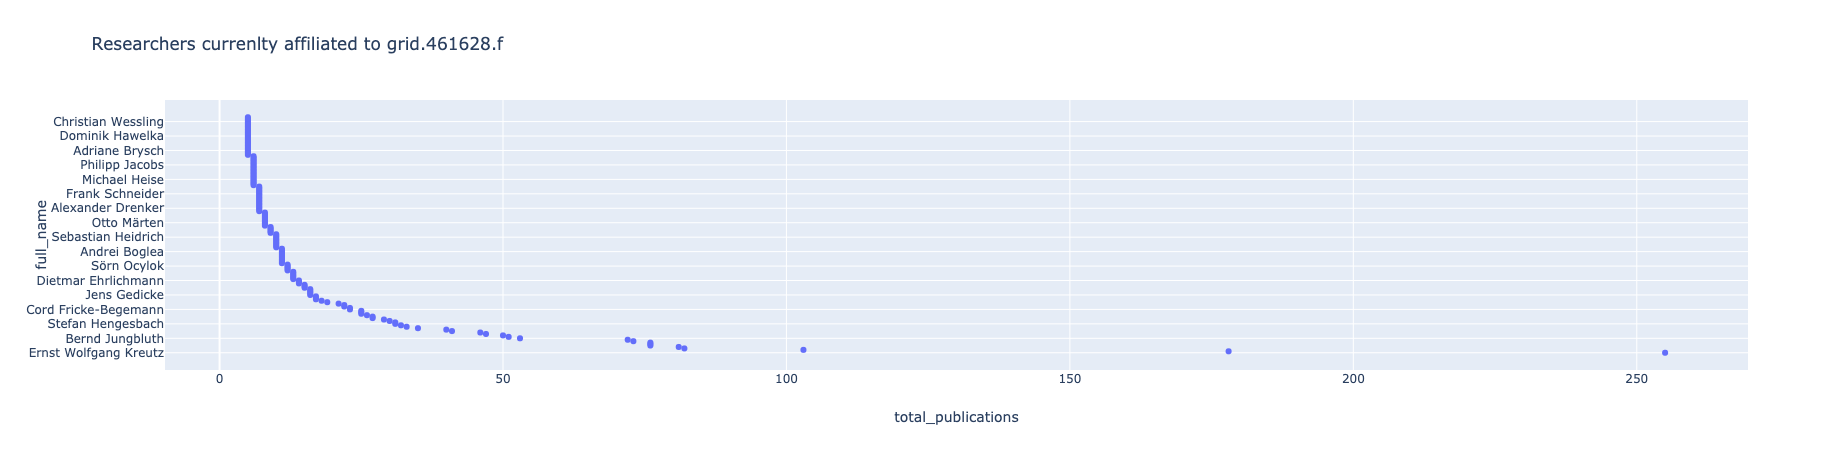

In [5]:
#@title Use the slider to select how many researchers to plot

limit1 = 164  #@param {type: "slider", min: 10, max: 1000}
#@markdown 

px.scatter(df1[:limit1], x="total_publications", y="full_name", 
           hover_name="full_name", 
           hover_data=['id', 'total_publications'], 
           height=600, title=f"Researchers currenlty affiliated to {GRIDID}")

### Historical Affiliations VS Current Affiliation: a quick look

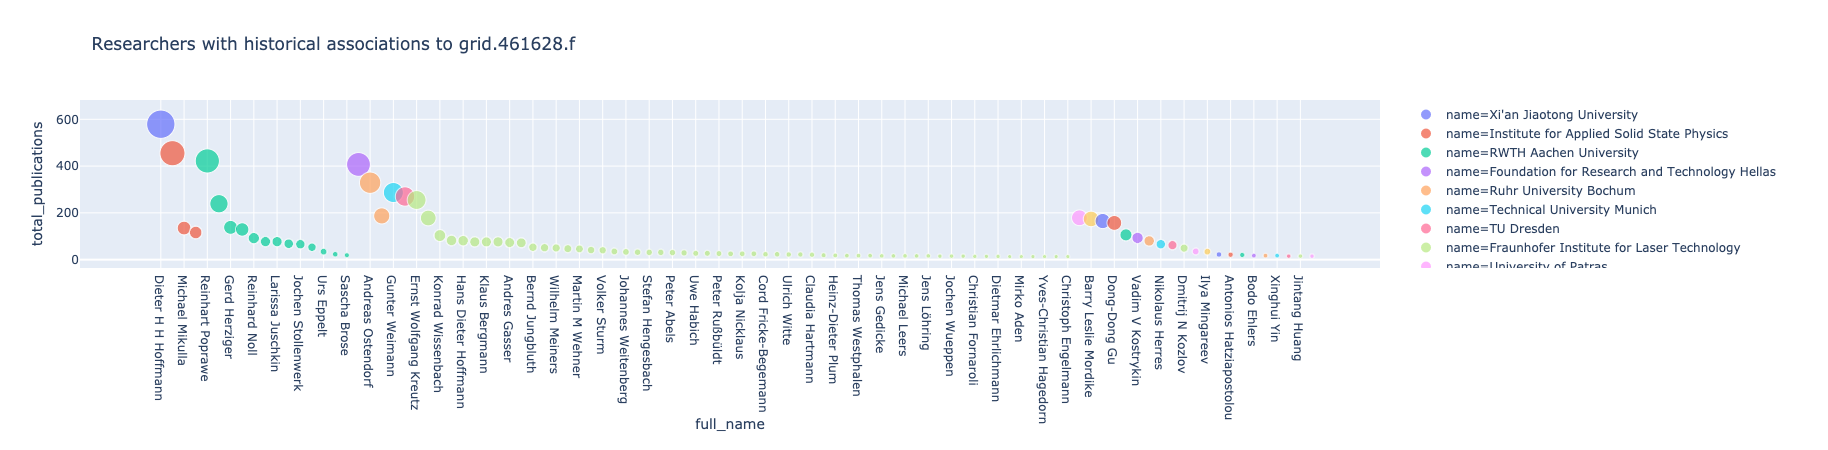

In [6]:
#@title Use the slider to select how many researchers to plot

limit2 = 100  #@param {type: "slider", min: 10, max: 1000}
#@markdown 

px.scatter(df2[:limit2], x="full_name", y="total_publications", hover_name="full_name", color="name", size="total_publications",
           hover_data=['id', 'total_publications'], 
           height=600, title=f"Researchers with historical associations to {GRIDID}")

### Distribution of researchers across receiving institutions/countries

By using the `current_research_org` value we can get a quick overview of where the researchers in our dataset are now.



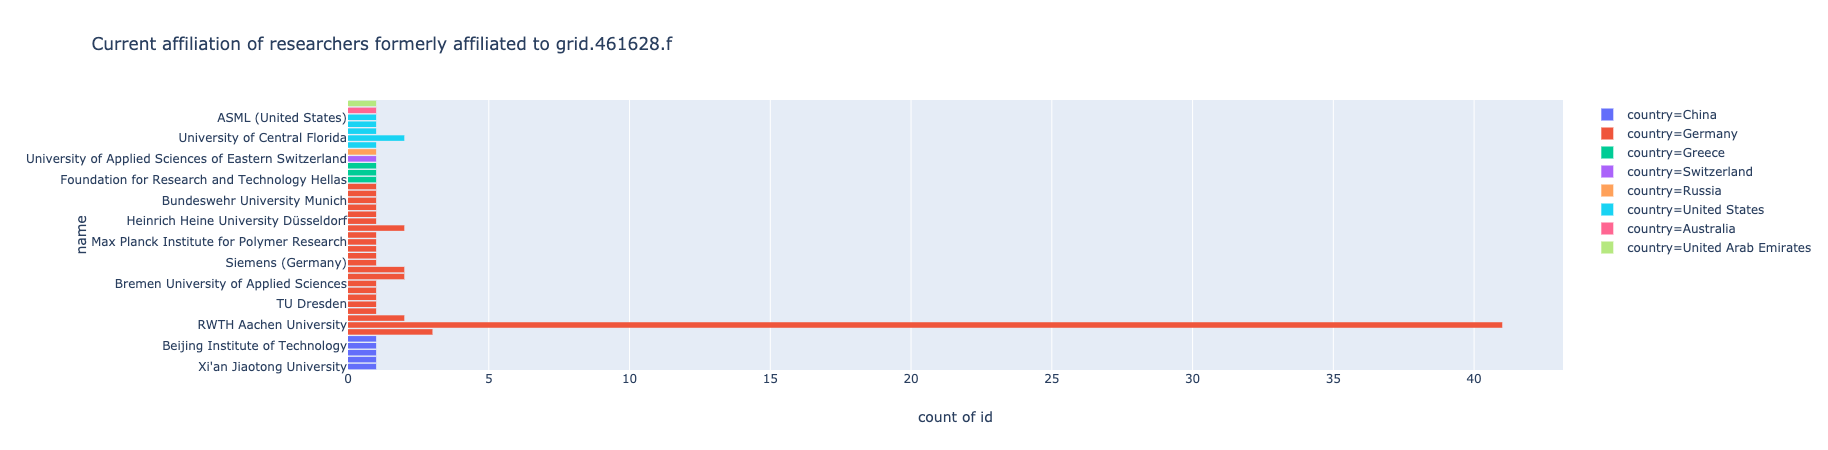

In [7]:
#@title Use the slider to select how many researchers to plot

limit3 = 343  #@param {type: "slider", min: 10, max: 1000}
#@markdown 

px.histogram(df3[:limit3], x="id", y="name", color="country",
             orientation='h', hover_name="name", 
             hover_data=['current_research_org.id'],
             title=f"Current affiliation of researchers formerly affiliated to {GRIDID}")

### Distribution of researchers segmented by tot number of high-impact publications 

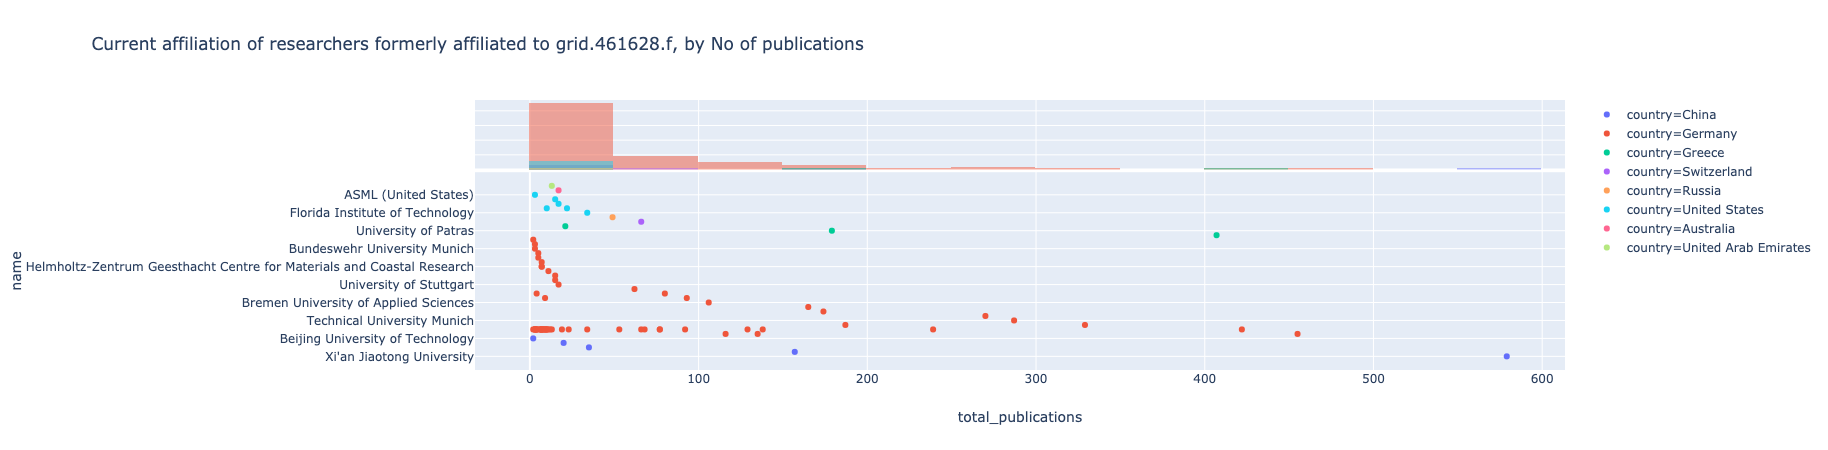

In [8]:
#@title Use the slider to select how many researchers to plot

limit4 = 100  #@param {type: "slider", min: 10, max: 1000}
#@markdown 

px.scatter(df3[:limit4], y="name", x="total_publications",  
           hover_name="full_name", marginal_x="histogram",
           color="country", hover_data=['id', 'total_publications'], 
           height=600, 
           title=f"Current affiliation of researchers formerly affiliated to {GRIDID}, by No of publications")

---
## Want to learn more?

Check out the [Dimensions API Lab](https://digital-science.github.io/dimensions-api-lab/) website, which contains many tutorials and reusable Jupyter notebooks for scholarly data analytics. 